# IML/PRSTIM project : NMR Signal & Peak Detection

Edwin Grappin & Guillaume Tochon

## Overall objective

This challenge works on nuclear magnetic resonance (NMR) observation to analyze leaves of plants. Studying leaves under RMN allows to understand the position of water within the cells.

Understanding the distribution of water in leaf cells is insightful to understand the level of senescence (the degradation due to the age) of the leaves.
Indeed, in advanced stage of senescence, the amount of water in the vacuoles increases. Measuring the level of senescence is useful to assess the impact of environmental factors on the plant. In particular, in R&D, some scientists think about using NMR to compare the efficacy of treatments (products that are applied to the plants to protect the plants from different stresses such as drought, heat, disease...).

In this settings processing NMR signals to assess the stage of senescence of plants could be used to discover new plants treatments.

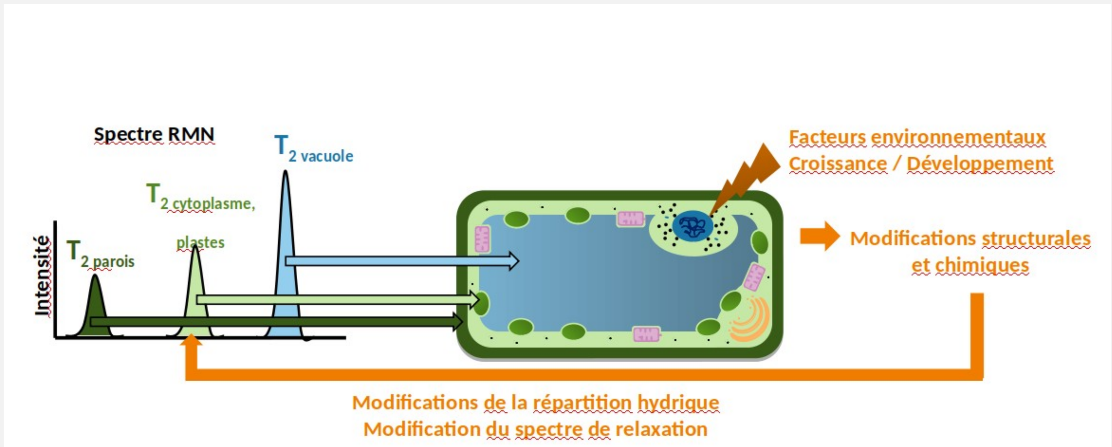

## Data description

Data are composed of leaf spectra (non-normalized densities) of T2 relaxation time (go read again your IMED course if you don't remember what is a T2 relaxation time), such as the one displayed below. The x-axis represents time (in ms) while the y-axis represent the intensity.

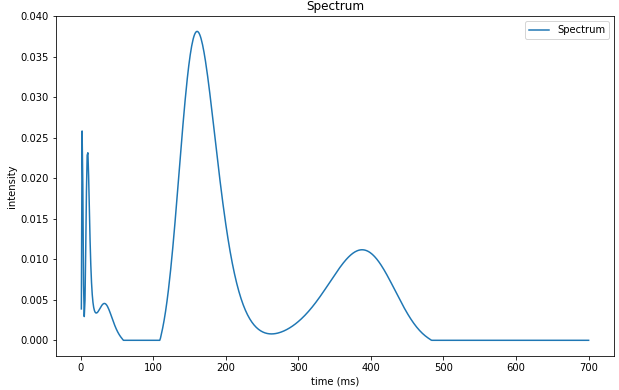

The spectrum is composed of peaks of various intensities and widths, and occuring at different relaxation times. Positions and intensities of the peaks correlate with the leaf age: the older the leaf, the higher the peak intensity and the later the relaxation time. 

Leaves are labeled by rank depending on their age on the plant.

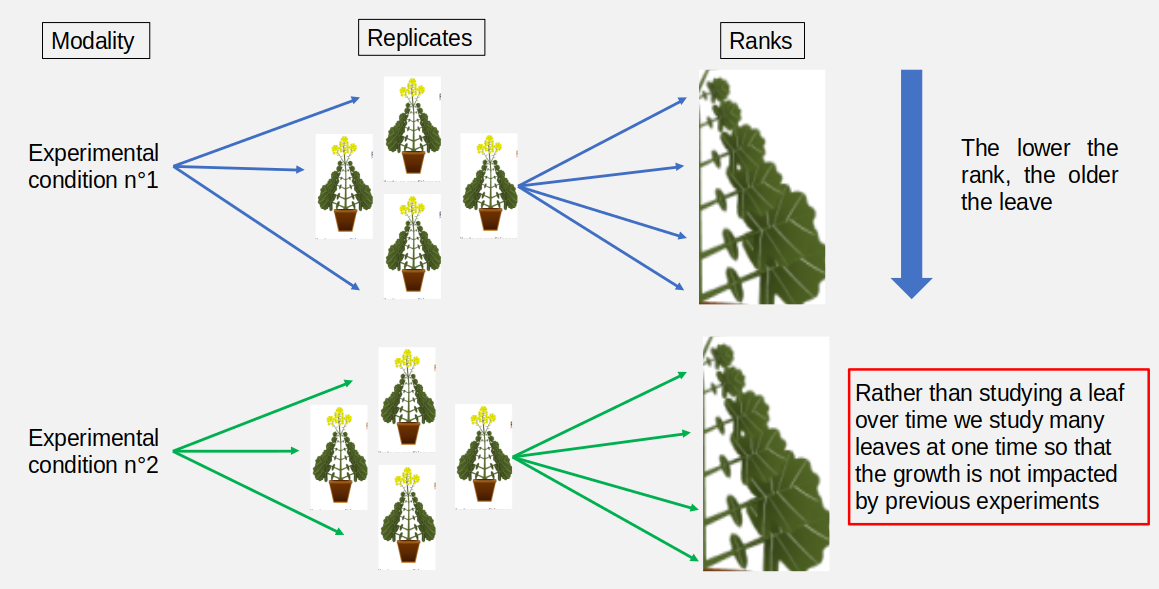


The higher the rank, the younger the leaf. In the figure below for instance, one can see the NMR response of a leaf getting older (from rank 6 to rank 3). At rank 6, there is a single peak with high intensity. Then, the T2 relaxation time of this peak is increasing in rank 5. In rank 4, the peak starts to split in two. At rank 3, the split is very clear. 

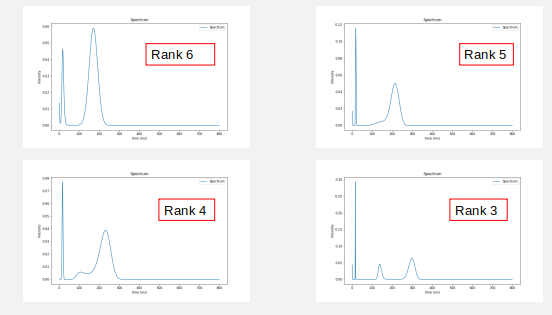


Information related to the number and the position of peaks in a given spectrum, as well as their intensity and width, are important information to caracterize the way a plant (and its leaves) react to environmental conditions and stress. 

## Goal of the project
The goal of this project is two-fold. First, detecting and classifying the type of peaks in the NMR spectra. Second, predicting their position. 
For that matter, you will have the opportunity to use different machine learning and data mining methods.

Inputs are organized as pj2 files (you can open them with python as any text files) describing the spectrum (with first column being the abscisse and the second column being the intensity of the signal). 

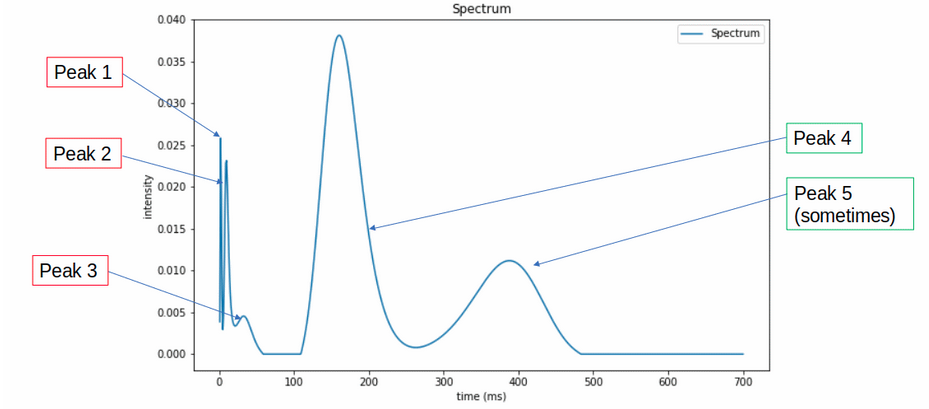

We are interested in the caracterization of 5 classes of peaks: 1, 2, 3, 4 and 5. 
Not all classes of peaks exist in every observation. The only structural link between peaks is that peak 5 exists only if peak 4 exists.

In order to train an estimator of peaks classes and the detection, you have access to 420 NMR signals and their associated peaks in the file data_nmr_input_epita_train.csv. A row is an observation, each column is the position in ms of the peak (if it exists). Therefore, your goal is to predict on each NMR observation which peak exist and then, provided it exists, to predict its position (in ms).

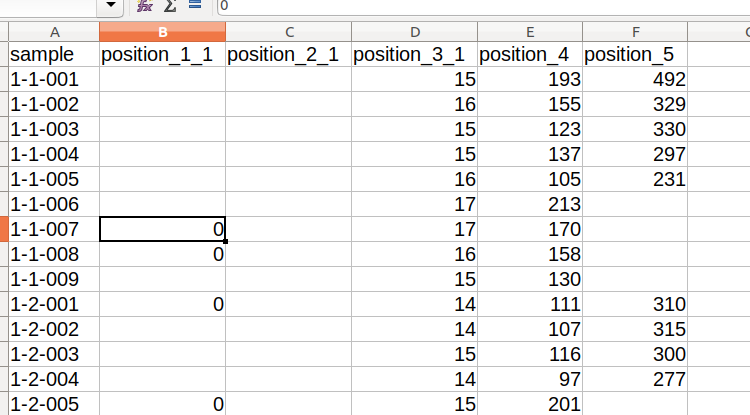

Data are organized in modality, replicate (observation) and rank. The file 7-3-001.pj2 is the NMR signal of the first rank of the 3 replicate of the modality 7. You have to extract and store the .zip file in the folder /app/Data/NMRBlue/LearningDataSet.

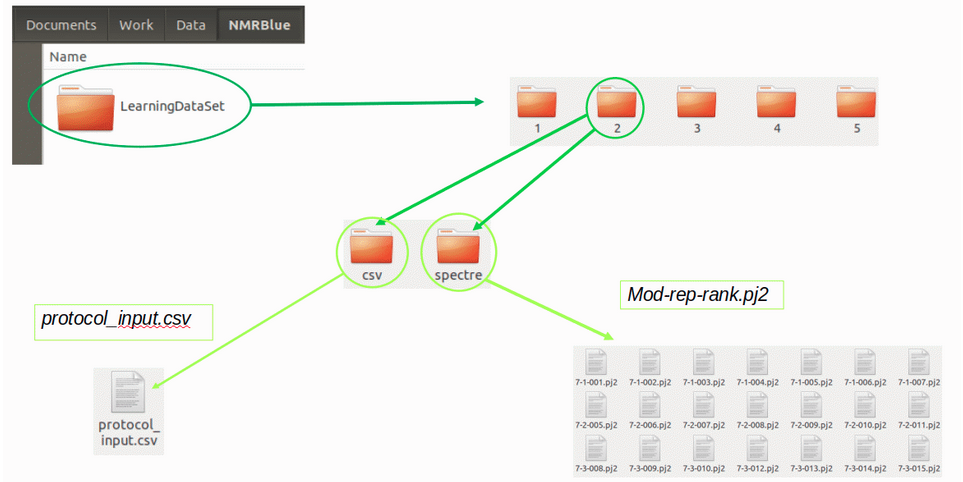

## Project organization 

Your output will be a jupyter lab notebook. The code should run (when docker container is ran) in this single jupyter notebook (but you can use other file that you import). Feel free to use markdown to explain and answer questions. Do not change container configuration. If extra installation is needed, please install directly in the notebook with `!pip install ...`. Your notebook should be self sufficient (within the docker container). 

You'll commit your results in your own branch called output/login1_login2<_login3> where _login1_ and _login2_ are your 2 EPITA logins (or 3 if you are three in the group). You will be working by groups of 2 for this project if you decide to commit your report by the end of August or by end of July if you decide to work in a group of 3.

The evaluation will be based on your ability to show that you understand machine learning concepts (such as clustering, classification) and notions related to statistics and probabilities. Good prediction performance will be valued as well, but a smart understanding of the topics and good choice of data processing and algorithms are what we are looking for. 

Due date: Last minute of July 2020 if you are a group of 3 or the last minute of August 2020 if you are a group of 2. 

In [1]:
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

The first sections (Parts 1, 2, 3 and 4) are mandatory. The "optional" section is... optional. 

## Part 1: understanding the data

**I.1)** Create a function that takes as argument a modality number, a replicate number and that plot a serie of spectrum. Plot the spectrum in the notebook. What can you say about the data. What are the range of values ? are the spectrums densities ? Why, why not ? Are the data in one replicate independent from each other ? 

In [2]:
spectrums = {}
for val in glob.glob(f'LearningDataSet/*/spectre/*'):
    with open(val) as f:
        file = []
        for line in f:
            temp = line.split(' ')
            if (len(temp) == 2):
                file.append([float(i) for i in temp])
    spectrums[val] = np.moveaxis(np.array(file), 1, 0)

In [3]:
def plot_spectrums(modality, replicate):
    ranks = glob.glob(f'LearningDataSet/{modality}/spectre/{modality}-{replicate}*')

    plt.figure(figsize = (15, 12))
    for i, val in enumerate(sorted(ranks)):
        sp = spectrums[val]
        plt.subplot(len(ranks)//3 + 1, 3, i+1)
        plt.plot(sp[0], sp[1], label=f'rank {i+1}')
        plt.xlabel("time (ms)")
        plt.ylabel("intensity")
        plt.legend()
    plt.show()

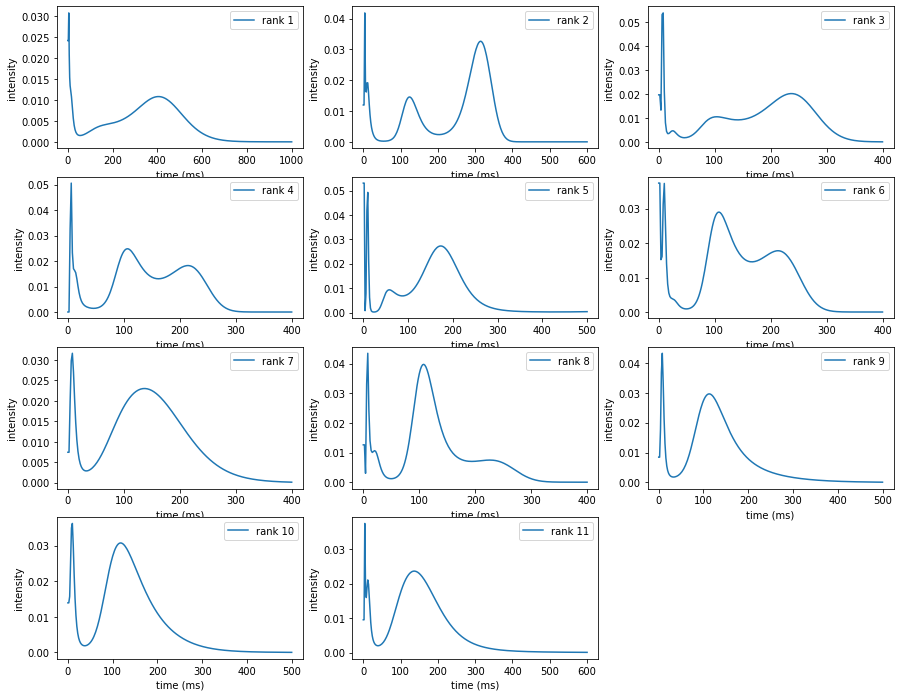

In [4]:
plot_spectrums(12, 3)

What are the range of values ? The range ov values change from one spectra to another because they are separate measurements.
ANSWER are the spectrums densities ? Why, why not ? Are the data in one replicate independent from each other ? 

**I.2)** Create a normalization function to turn all spectra into density probability functions.

In [5]:
def normalize_all():
    for key in spectrums:
        spectrums[key][0] /= spectrums[key][0].max()
        # density probability function -> AUC=1
        auc = np.trapz(spectrums[key][1], x=spectrums[key][0])
        spectrums[key][1] = spectrums[key][1]/auc
        

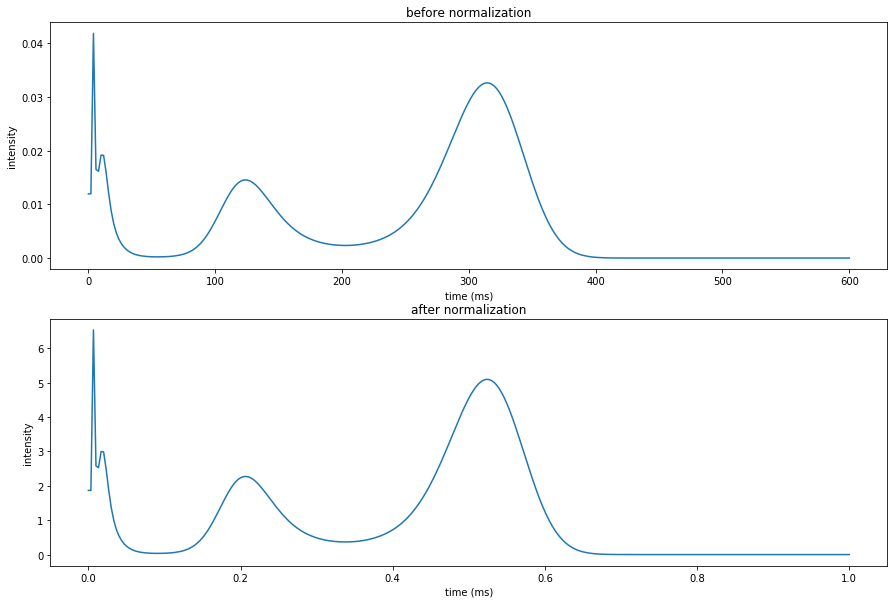

In [6]:
plt.figure(figsize=(15, 10))

spec = spectrums['LearningDataSet/12/spectre/12-3-002.pj2']

plt.subplot(211)
plt.plot(spec[0], spec[1])
plt.xlabel("time (ms)")
plt.ylabel("intensity")
plt.title('before normalization')


normalize_all()

norm = spectrums['LearningDataSet/12/spectre/12-3-002.pj2']

plt.subplot(212)
plt.plot(norm[0], norm[1])
plt.xlabel("time (ms)")
plt.ylabel("intensity")
plt.title('after normalization')

plt.show()

In [7]:
print('area under the curve =', np.trapz(norm[1], x=norm[0]))

area under the curve = 1.0


## Part 2: Clustering approach and sampling to estimate the number of peaks.

The goal of this section is to try and differentiate the rank of the various spectra you have at hand with clustering approaches. The main issue comes from the fact that it is merely impossible to classify high dimensional data (that is, if you consider each spectrum as a vector whose dimension is the number of samples in the spectrum) without any prior dimension reduction method. So, let's try another approach, whose overall idea is the following : instead of clustering the spectra on their own, you are going to generate random variables out of those spectra (after proper normalization to turn the spectrum into a probability density function), and it is this bunch of random variables that you are going to cluster instead.

**II.1)** generate some scalar random variables from a given normalized spectrum, 

In [8]:
def secondDerivative(x):
    dev = []
    for i in range(len(x)):
        val = - 2 * x[i]
        if (i != len(x)-1):
            val+=x[i+1]
        if (i != 0):
            val+=x[i-1]
        dev.append(val)
    return dev

In [9]:
np.random.seed(50)

In [10]:
example = spectrums['LearningDataSet/12/spectre/12-2-005.pj2']

def random_var(spectrum, samples=100):
    # threshold to only keep values on peaks
    X_sup = example[:, (np.where(spectrum[1]> 1.5)[0])]
    X = np.random.choice(X_sup[0], samples, p=X_sup[1] / np.sum(X_sup[1]))
    Y = [X_sup[1][np.where(X_sup[0]==val)[0]] for val in X]
    return X, Y

X, Y = random_var(example)

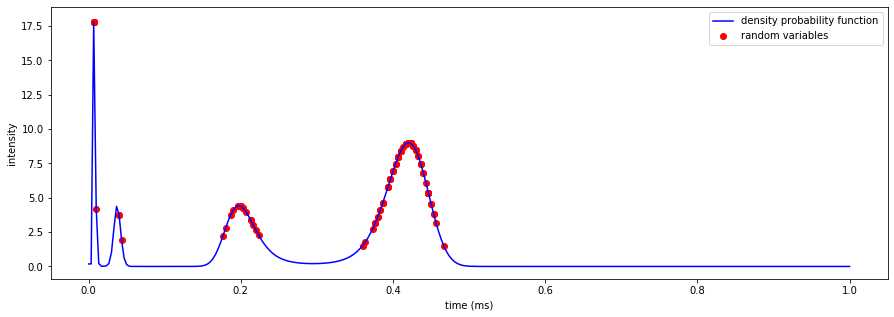

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(example[0], example[1], label='density probability function', c='b')
plt.scatter(np.squeeze(X), Y, c='r', label='random variables')
plt.xlabel("time (ms)")
plt.ylabel("intensity")
plt.legend()
plt.show()


**II.2)** for each NMR observation run a clustering algorithm to generate up to five clusters. 

In [12]:
X = np.expand_dims(X, axis=1)
# X = np.squeeze(np.stack((X, np.array(Y)*X)))

In [14]:
pred=[]
inertia=[]
centers=[]
distortions=[]
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=1).fit(X)
    kmeans.fit(X) 
    centers.append(kmeans.cluster_centers_)
    pred.append(kmeans.predict(X))
    inertia.append(kmeans.inertia_)
    dist = cdist(X, kmeans.cluster_centers_, 'euclidean')
    distortions.append(sum(np.min(dist, axis=1)) / X.shape[0])

dev = secondDerivative(inertia)

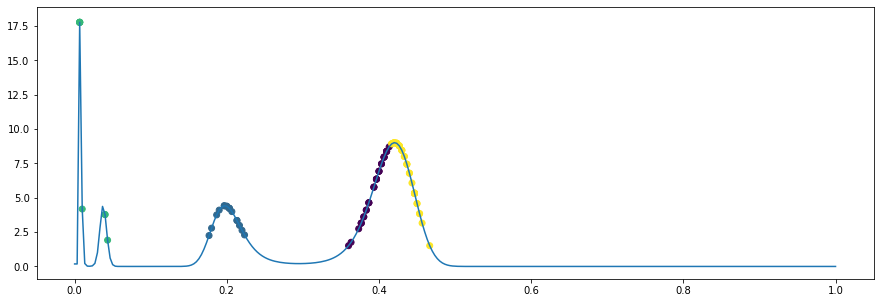

In [15]:
i=3

plt.figure(figsize=(15, 5))
plt.plot(example[0], example[1])
plt.scatter(np.squeeze(X), Y, c=pred[i])

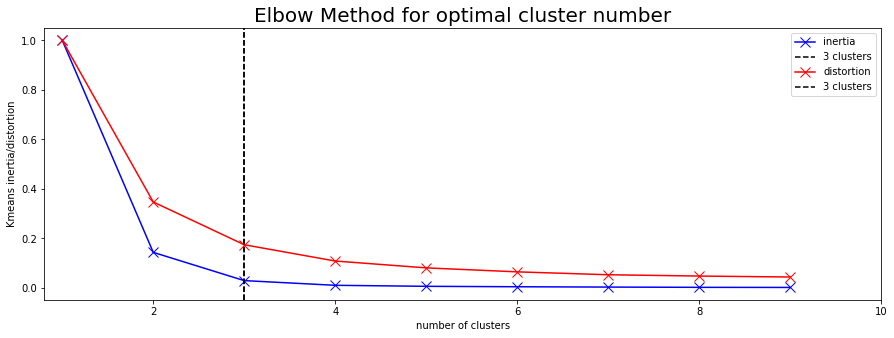

In [16]:
plt.figure(figsize=(15, 5))

# Elbow Method

dev = secondDerivative(inertia)
k_opt_e = np.where(dev==max(dev))[0][0]+2

plt.title('Elbow Method for optimal cluster number', size=20)
plt.plot(range(1, 10), inertia/max(inertia), 'bx-', markersize=10, label='inertia')
plt.axvline(x=k_opt_e, color='k', linestyle='--', label=f'{k_opt_e} clusters')

plt.plot(range(1, 10), distortions/max(distortions), 'rx-', markersize=10, label='distortion')
plt.ylabel('Kmeans inertia/distortion')
plt.xlabel('number of clusters')
plt.axvline(x=k_opt_e, color='k', linestyle='--', label=f'{k_opt_e} clusters')

plt.legend()
plt.xlim((0.8, 10))


plt.show()

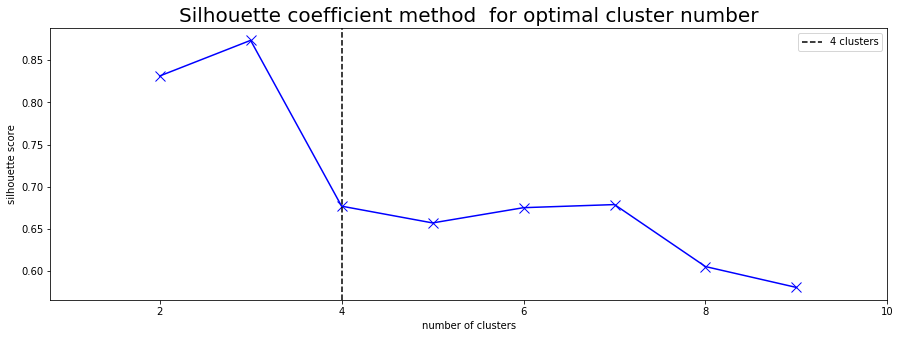

In [17]:
plt.figure(figsize=(15, 5))

# Silhouette Method

sils = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X.reshape(-1, 1))
    label = kmeans.labels_
    sil_coeff = silhouette_score(X.reshape(-1, 1), label, metric='euclidean')
    sils.append(sil_coeff)
k_opt_s = np.argmax(sils) + 3
    
plt.plot(range(2, 10), sils, 'bx-', markersize=10)
plt.axvline(x=k_opt_s, color='k', linestyle='--', label=f'{k_opt_s} clusters')
plt.ylabel('silhouette score')
plt.xlabel('number of clusters')
plt.legend()
plt.xlim((0.8, 10)) 
plt.title('Silhouette coefficient method  for optimal cluster number', size=20)
plt.show()

**II.3)** Estimate the number of peaks. Create an evaluation rule to decide what is the best number of clusters to use (considering that you know the number of peaks thanks to the CSV) in order to minimize the sum of absolute difference between the estimated number of peaks and the ground truth number of peaks in an NMR observation.

In [18]:
nmr_train = pd.read_csv("LearningDataSet/data_nmr_input_epita_train.csv")
# nmr_train.loc[nmr_train.loc[ : , 'sample' ].str.match('10-1-*') == True]
nmr_train

,sample,position_1_1,position_2_1,position_3_1,position_4,position_5
0,1-1-001,NaN,NaN,15.0,193.0,492.0
1,1-1-002,NaN,NaN,16.0,155.0,329.0
2,1-1-003,NaN,NaN,15.0,123.0,330.0
3,1-1-004,NaN,NaN,15.0,137.0,297.0
4,1-1-005,NaN,NaN,16.0,105.0,231.0
...,...,...,...,...,...,...
415,12-4-006,NaN,8.0,NaN,136.0,NaN
416,12-4-007,0.0,6.0,12.0,96.0,202.0
417,12-4-008,0.0,NaN,14.0,166.0,NaN
418,12-4-009,NaN,6.0,NaN,161.0,NaN


In [20]:
def get_pic_num(mod=None, repl=None, rank=None,key=None):
    if key:
        return np.sum(nmr_train.loc[nmr_train.loc[ : , 'sample' ] == key.split('/')[-1][:-4]].count()) - 1
    else:
        return np.sum(nmr_train.loc[nmr_train.loc[ : , 'sample' ] == f"{mod}-{repl}-"+rank].count()) - 1

In [21]:
peaks = get_pic_num(1, 1, '001')
print(f"There are {peaks} peaks in row 0")
peaks = get_pic_num(12, 4, '007')
print(f"There are {peaks} peaks in row 416")

There are 3 peaks in row 0
There are 5 peaks in row 416


In [22]:
tot_err = 0
for l, key in enumerate(spectrums):
    example = spectrums[key]
    X, Y = random_var(example)
    X = np.expand_dims(X, axis=1)
    error_s = 0
    sils = []
    #silhouette
    for i in range(2, 10):
        error_s = 0
        kmeans = KMeans(n_clusters=i, random_state=1).fit(X.reshape(-1, 1))
        label = kmeans.labels_
        sil_coeff = silhouette_score(X.reshape(-1, 1), label, metric='euclidean', random_state=15)
        sils.append(sil_coeff)
    sil = np.argmax(sils) + 3
    real = get_pic_num(key=key)
    error_s += abs(real - sil)
    tot_err += error_s

print(f'TOTAL ERROR IS {tot_err} for {len(spectrums.keys())} peaks!')

TOTAL ERROR IS 292 for 401 peaks!


## Part 3: Classification

Let's assume for a moment that you know the number of peaks in each observation. (you can count them from the csv file). The goal of this section is to classify these peaks from type 1 to type 5. 

**III.1)** generate some features from the clusters you created in Part 2 to classify peaks in their type (1, 2, 3, 4, 5).

**III.2)** What classification method would you use?

  Je sais pas trop comment on peux justifier ça

**III.3)** Run a classification method on each selected clusters and classify each peak you have identified. What is the accuracy of your method. Can you plot the confusion matrix ? 

**III.4)** Create an estimator of the position of a peak. 

## Part 4 : Putting things together. 

Part 2 was about counting the number of peaks while Part 3 was about characterizing peaks types. The goal of this section is to generate a complete workflow that estimates the peak types and positions existing in a given NMR spectrum. We suggest that you use Parts 2 and 3 to do so, but this is in no way mandatory.

In order to score this section we will run your function on a dataset that you don't have access to. But you can train your estimator on the training dataset you have access to (the data we use for testing are quite similar).

Your function should take a list of modalities, scrap all the existing replicates in these modalities folders and return a csv in the same shape as the one in the training dataset. 

Four loss functions will be used to evaluate the quality of your estimator:
- The absolute difference between the number of detected peaks and the real number of peaks. 
- For each detected peaks the accuracy of its classification type. 
- For each detected peaks the square of the difference between the ground truth position and the estimated position. 

Your function should read a skeleton CSV of 6 columns: 
The first column will indicate the modality-replicate-rank to read for the prediction. Then your function should write in the CSV your estimation of peak 1 to 5 position. 
To help you, we created in advance the skeleton of the CSV. Then you should write your result in a new csv name "result.csv" stored in /app/Data/NMRBlue/LearningDataSet. 

It will be compared with the ground truth CSV with the following code:

In [20]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


pred_peak = pd.read_csv("/app/Data/NMRBlue/LearningDataSet/result.csv", index_col=0)
gt_peak = pd.read_csv("/app/Data/NMRBlue/LearningDataSet/gt.csv", index_col=0)

FileNotFoundError: [Errno 2] File /app/Data/NMRBlue/LearningDataSet/result.csv does not exist: '/app/Data/NMRBlue/LearningDataSet/result.csv'

In [ ]:
def counting_number_peak(df):
    res = df.count(axis=1, level=None, numeric_only=True)
    return res

def mae_count(gt, pred):
    count_gt = counting_number_peak(gt)
    count_pred = counting_number_peak(pred)
    mae = mean_absolute_error(count_gt, count_pred)
    return mae

In [ ]:
# Score MAE
mae_count(gt_peak, pred_peak)

In [ ]:
def flat(df):
    flatten = df.to_numpy().flatten()
    return flatten
def flat_boolean(df):
    flatten = flat(df)
    bool_flatten = ~np.isnan(flatten)
    return bool_flatten
    

In [ ]:
boolean_gt = flat_boolean(gt_peak)
boolean_pred = flat_boolean(pred_peak)
accuracy_score(boolean_gt, boolean_pred)

In [ ]:
flat_gt = flat(gt_peak)
flat_pred = flat(pred_peak)
not_nan_gt = ~np.isnan(flat_gt)
flat_gt = flat_gt[not_nan_gt]
flat_pred = flat_pred[not_nan_gt]

not_nan_pred = ~np.isnan(flat_pred)
flat_gt = flat_gt[not_nan_pred]
flat_pred = flat_pred[not_nan_pred]

sklearn.metrics.mean_squared_error(flat_gt, flat_pred)

## Optional part: Bayesian or Deep Learning peak detection
For those who want to, you could apply this if you want to dig bayesian stat:
https://www.researchgate.net/publication/258252347_Bayesian_Peak_Picking_for_NMR_Spectra
Or this if you want to dig CNN in NMR (adjustment to single dimension will be needed)
https://academic.oup.com/bioinformatics/article/34/15/2590/4934937
